In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy as sc
from itertools import product
from dateutil.relativedelta import relativedelta
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [235]:
data=pd.read_csv('WAG_C_M.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WAG_C_M       284 non-null    float64
 1   box_zp        284 non-null    float64
 2   box_zp_diff   272 non-null    float64
 3   box_zp_diff2  271 non-null    float64
dtypes: float64(4)
memory usage: 11.1 KB


Выведем данные на экран, посомтрим, стаицонарны ли они на глаз, после этого проверим критерием Дики-Фулера на стационарность

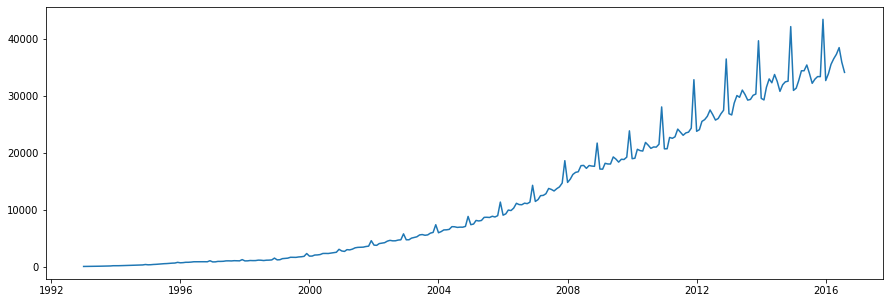

In [40]:
plt.figure(figsize=[15,5])
plt.plot(data.WAG_C_M)

In [41]:
import statsmodels.api as sm

Итак видим что данные не стационарны и имеют сезонность, сначала для убедительности проверим их критерием Дики-Фулера. Сделаем для этого функцию proverka

Критерий Дики-Фуллера: p=0.991850


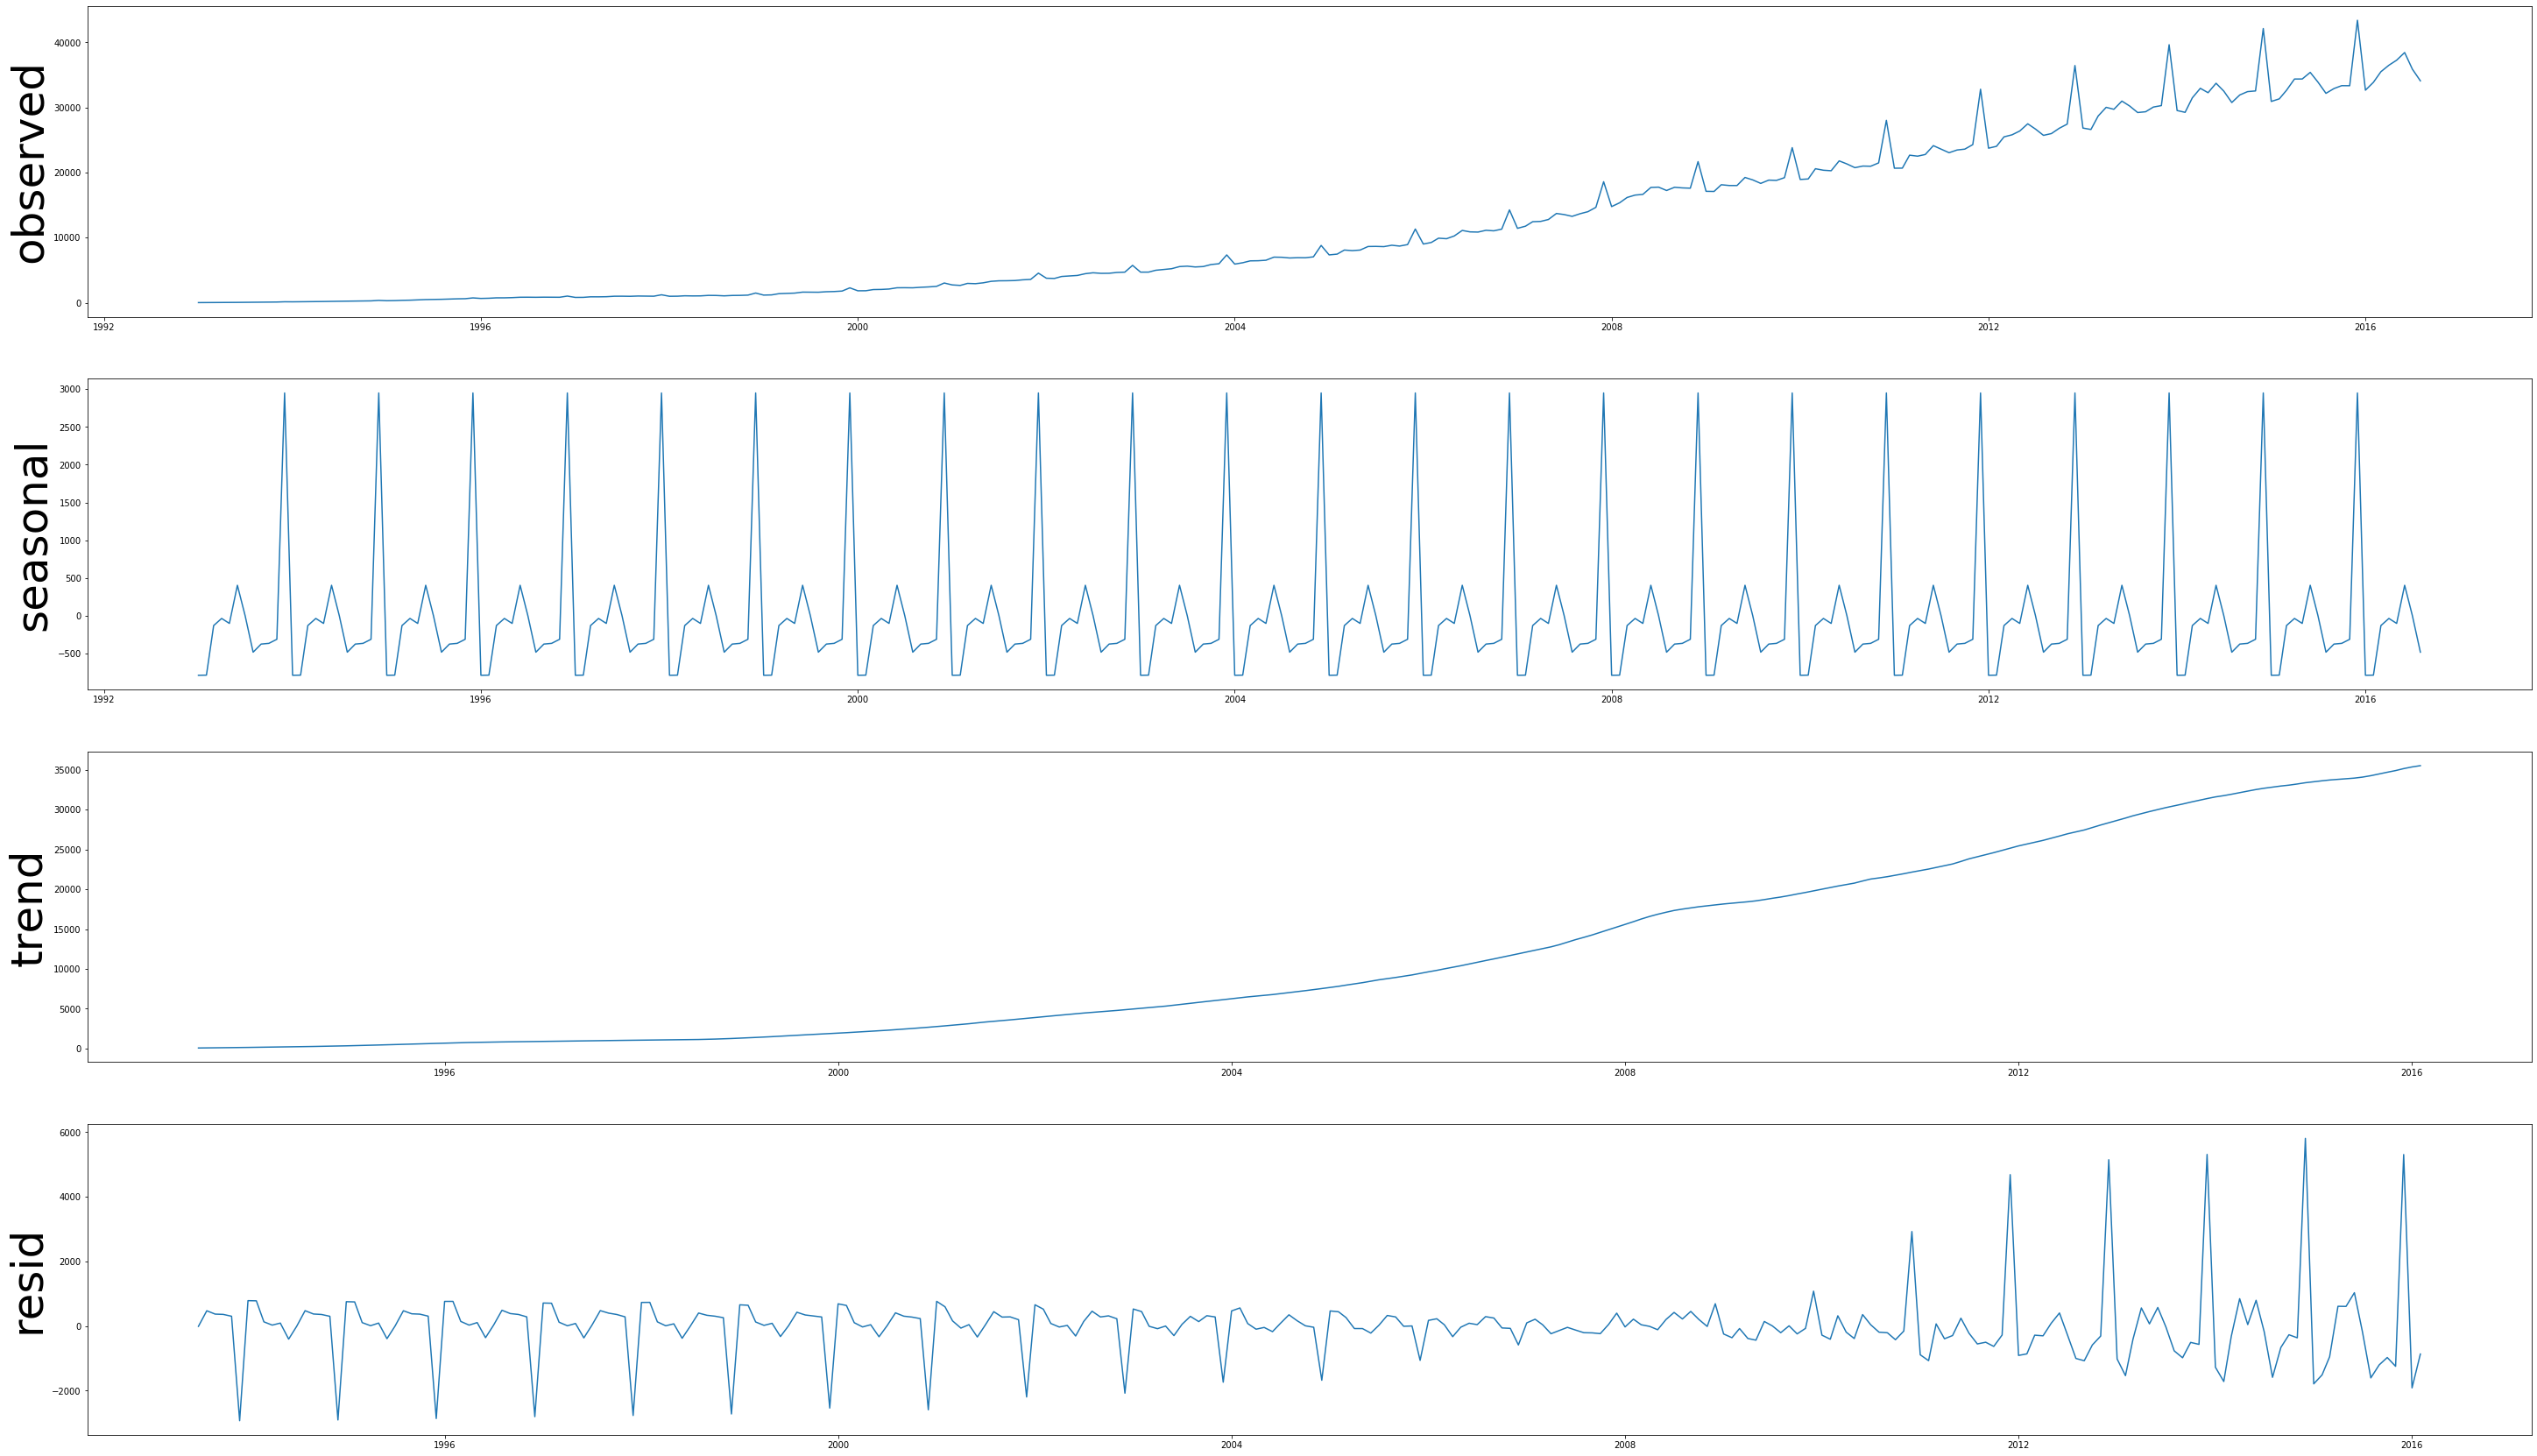

In [90]:
def proverka(data):
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data)[1])
    fig=plt.figure(figsize=[50,30])
    ses_dec=sm.tsa.seasonal_decompose(data)
    ax0 = plt.subplot(4,1,1)
    ax0.plot(ses_dec.observed)
    plt.ylabel('observed', size=50)
    ax1 = plt.subplot(4,1,2)
    ax1.plot(ses_dec.seasonal)
    plt.ylabel('seasonal', size=50)
    ax2 = plt.subplot(4,1,3)
    ax2.plot(ses_dec.trend)
    plt.ylabel('trend', size=50)
    ax3 = plt.subplot(4,1,4)
    ax3.plot(ses_dec.resid)
    plt.ylabel('resid', size=50)
proverka(data)

Гипотеза о нестационарности подтверждается (pvalue>0,05)

#### 1. Для стабилизации дисперсии, сделаем преобразование Бокса-Кокса

In [95]:
data['box_zp'], lmbda =sc.stats.boxcox(data.WAG_C_M)

In [234]:
lmbda

0.2632017541844584

Дики Фулер pvalue= 0.6968987634832758


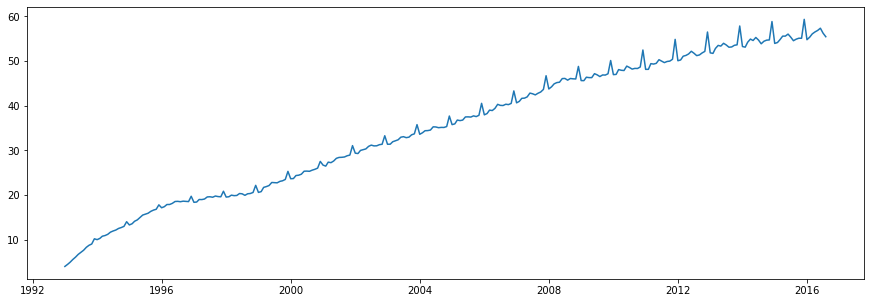

In [100]:
print('Дики Фулер pvalue=' , sm.tsa.adfuller(data.box_zp)[1])
plt.figure(figsize=[15,5])
plt.plot(data.box_zp)

#### 2. Данные до сих пор не стационарны. Применим сезонное дифференцирование

In [101]:
data['box_zp_diff']=data.box_zp-data.box_zp.shift(12)

,WAG_C_M,box_zp,box_zp_diff
month,,,
1993-01-01,15.3,3.990393,NaN
1993-02-01,19.1,4.458758,NaN
1993-03-01,23.6,4.931635,NaN
1993-04-01,30.6,5.549430,NaN
1993-05-01,37.5,6.063406,NaN


Проверяем полученные графики наблюдений/сезонности/тренда и гипотезу стационарности

Критерий Дики-Фуллера: p=0.014697


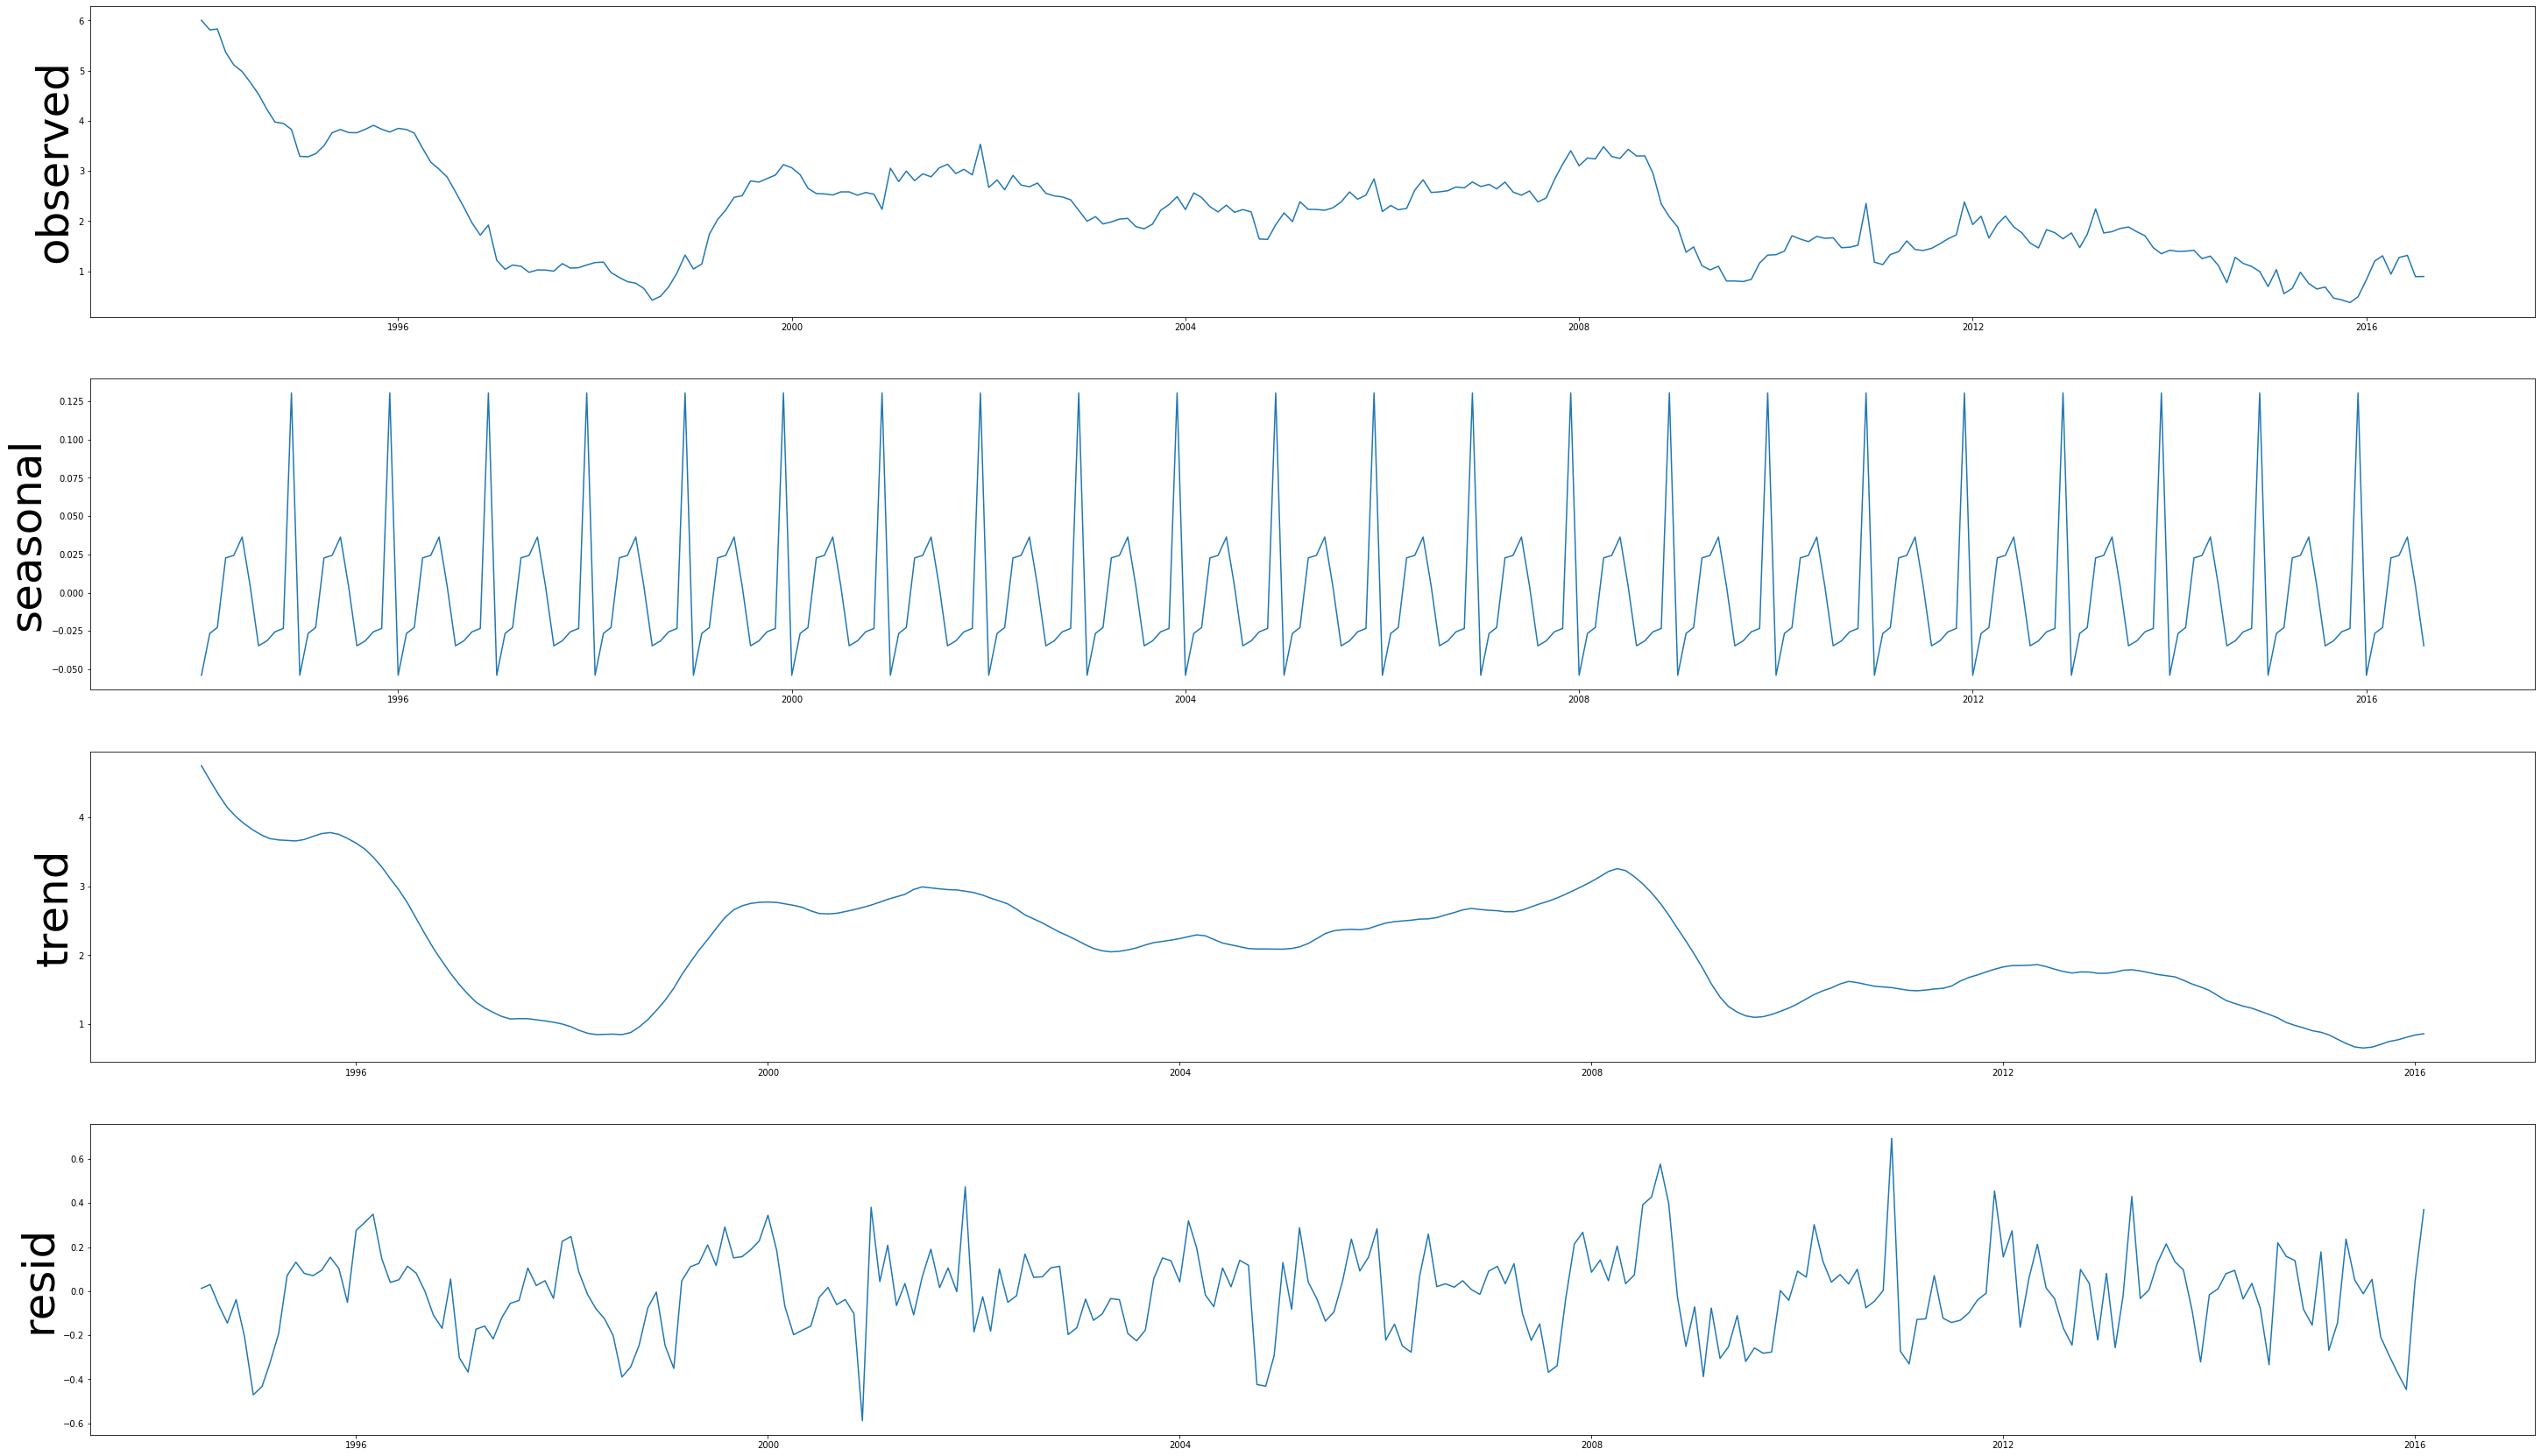

In [104]:
proverka(data.box_zp_diff.iloc[12:])

#### 3. Тренд до сих пор присутствует, применим обычное дифференцирование (хоть и гипотеза нестационарности отвергается))

In [106]:
data['box_zp_diff2']=data.box_zp_diff-data.box_zp_diff.shift(1)

Проверяем полученные графики наблюдений/сезонности/тренда и гипотезу стационарности

Критерий Дики-Фуллера: p=0.000000


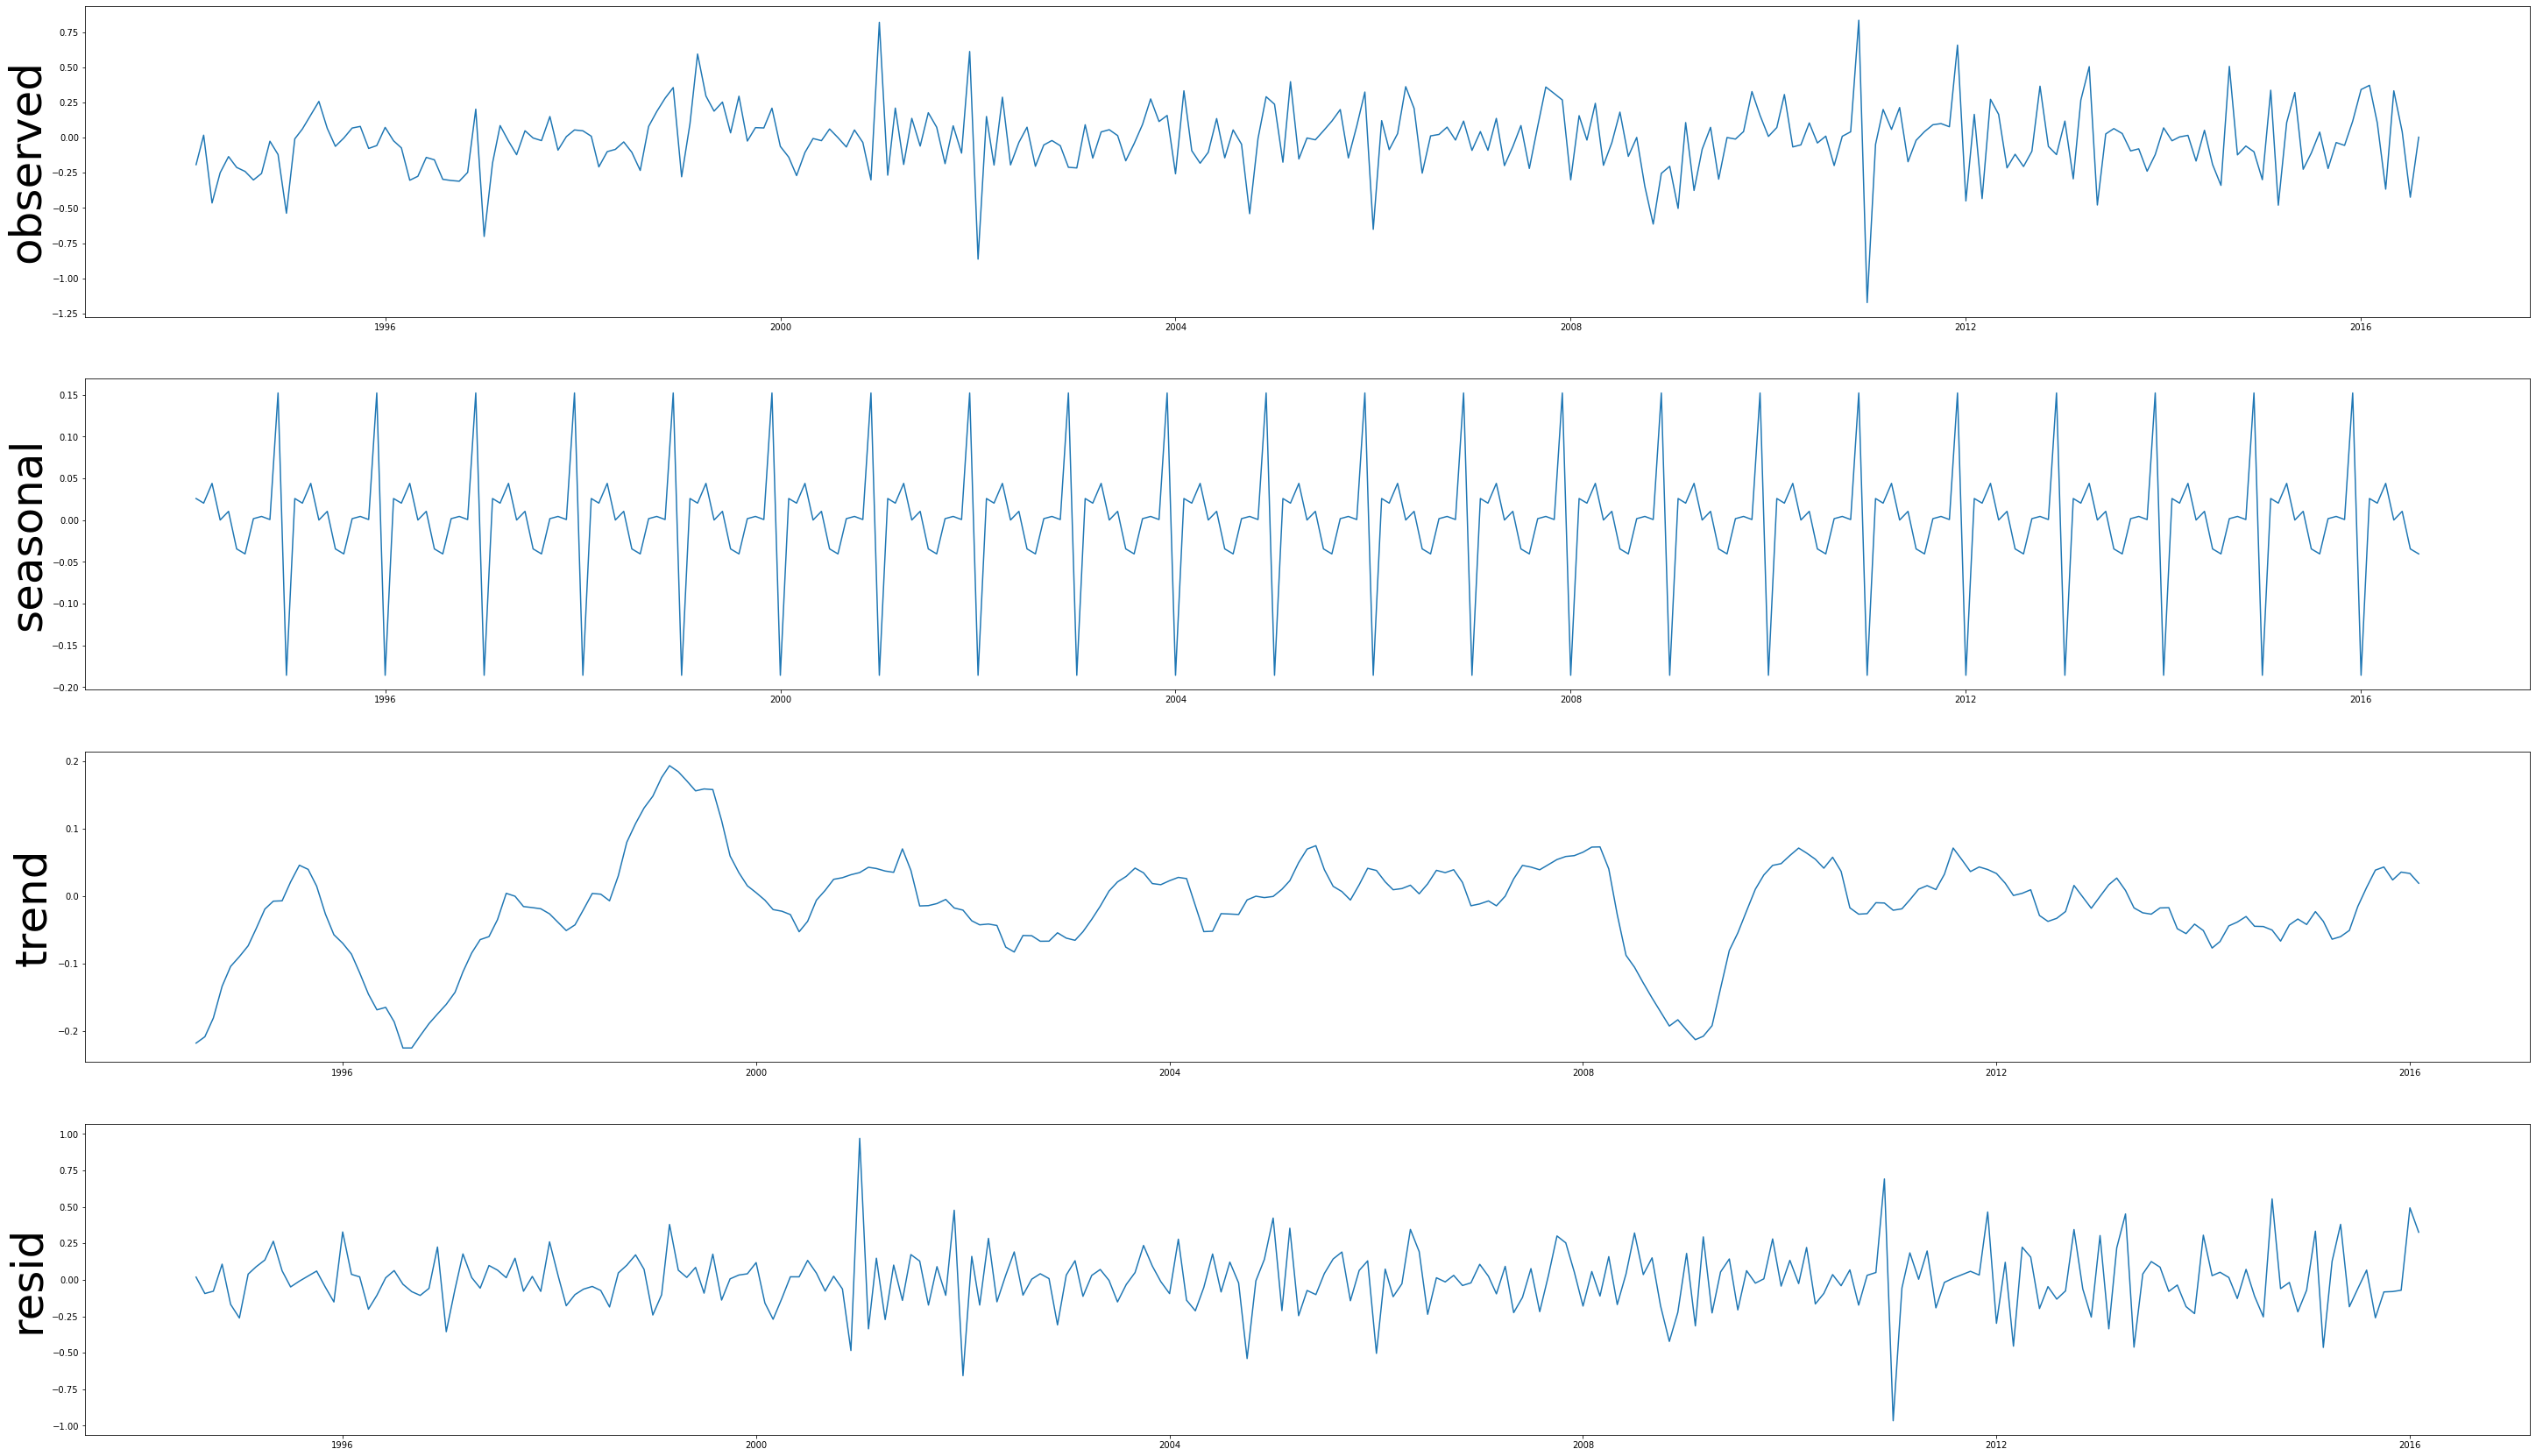

In [108]:
proverka(data.box_zp_diff2.iloc[13:])

Тренд больше ненаблюдается, гипотеза нестационарности отвергается

### Подбор модели

### 1. Определим p,q,P,Q

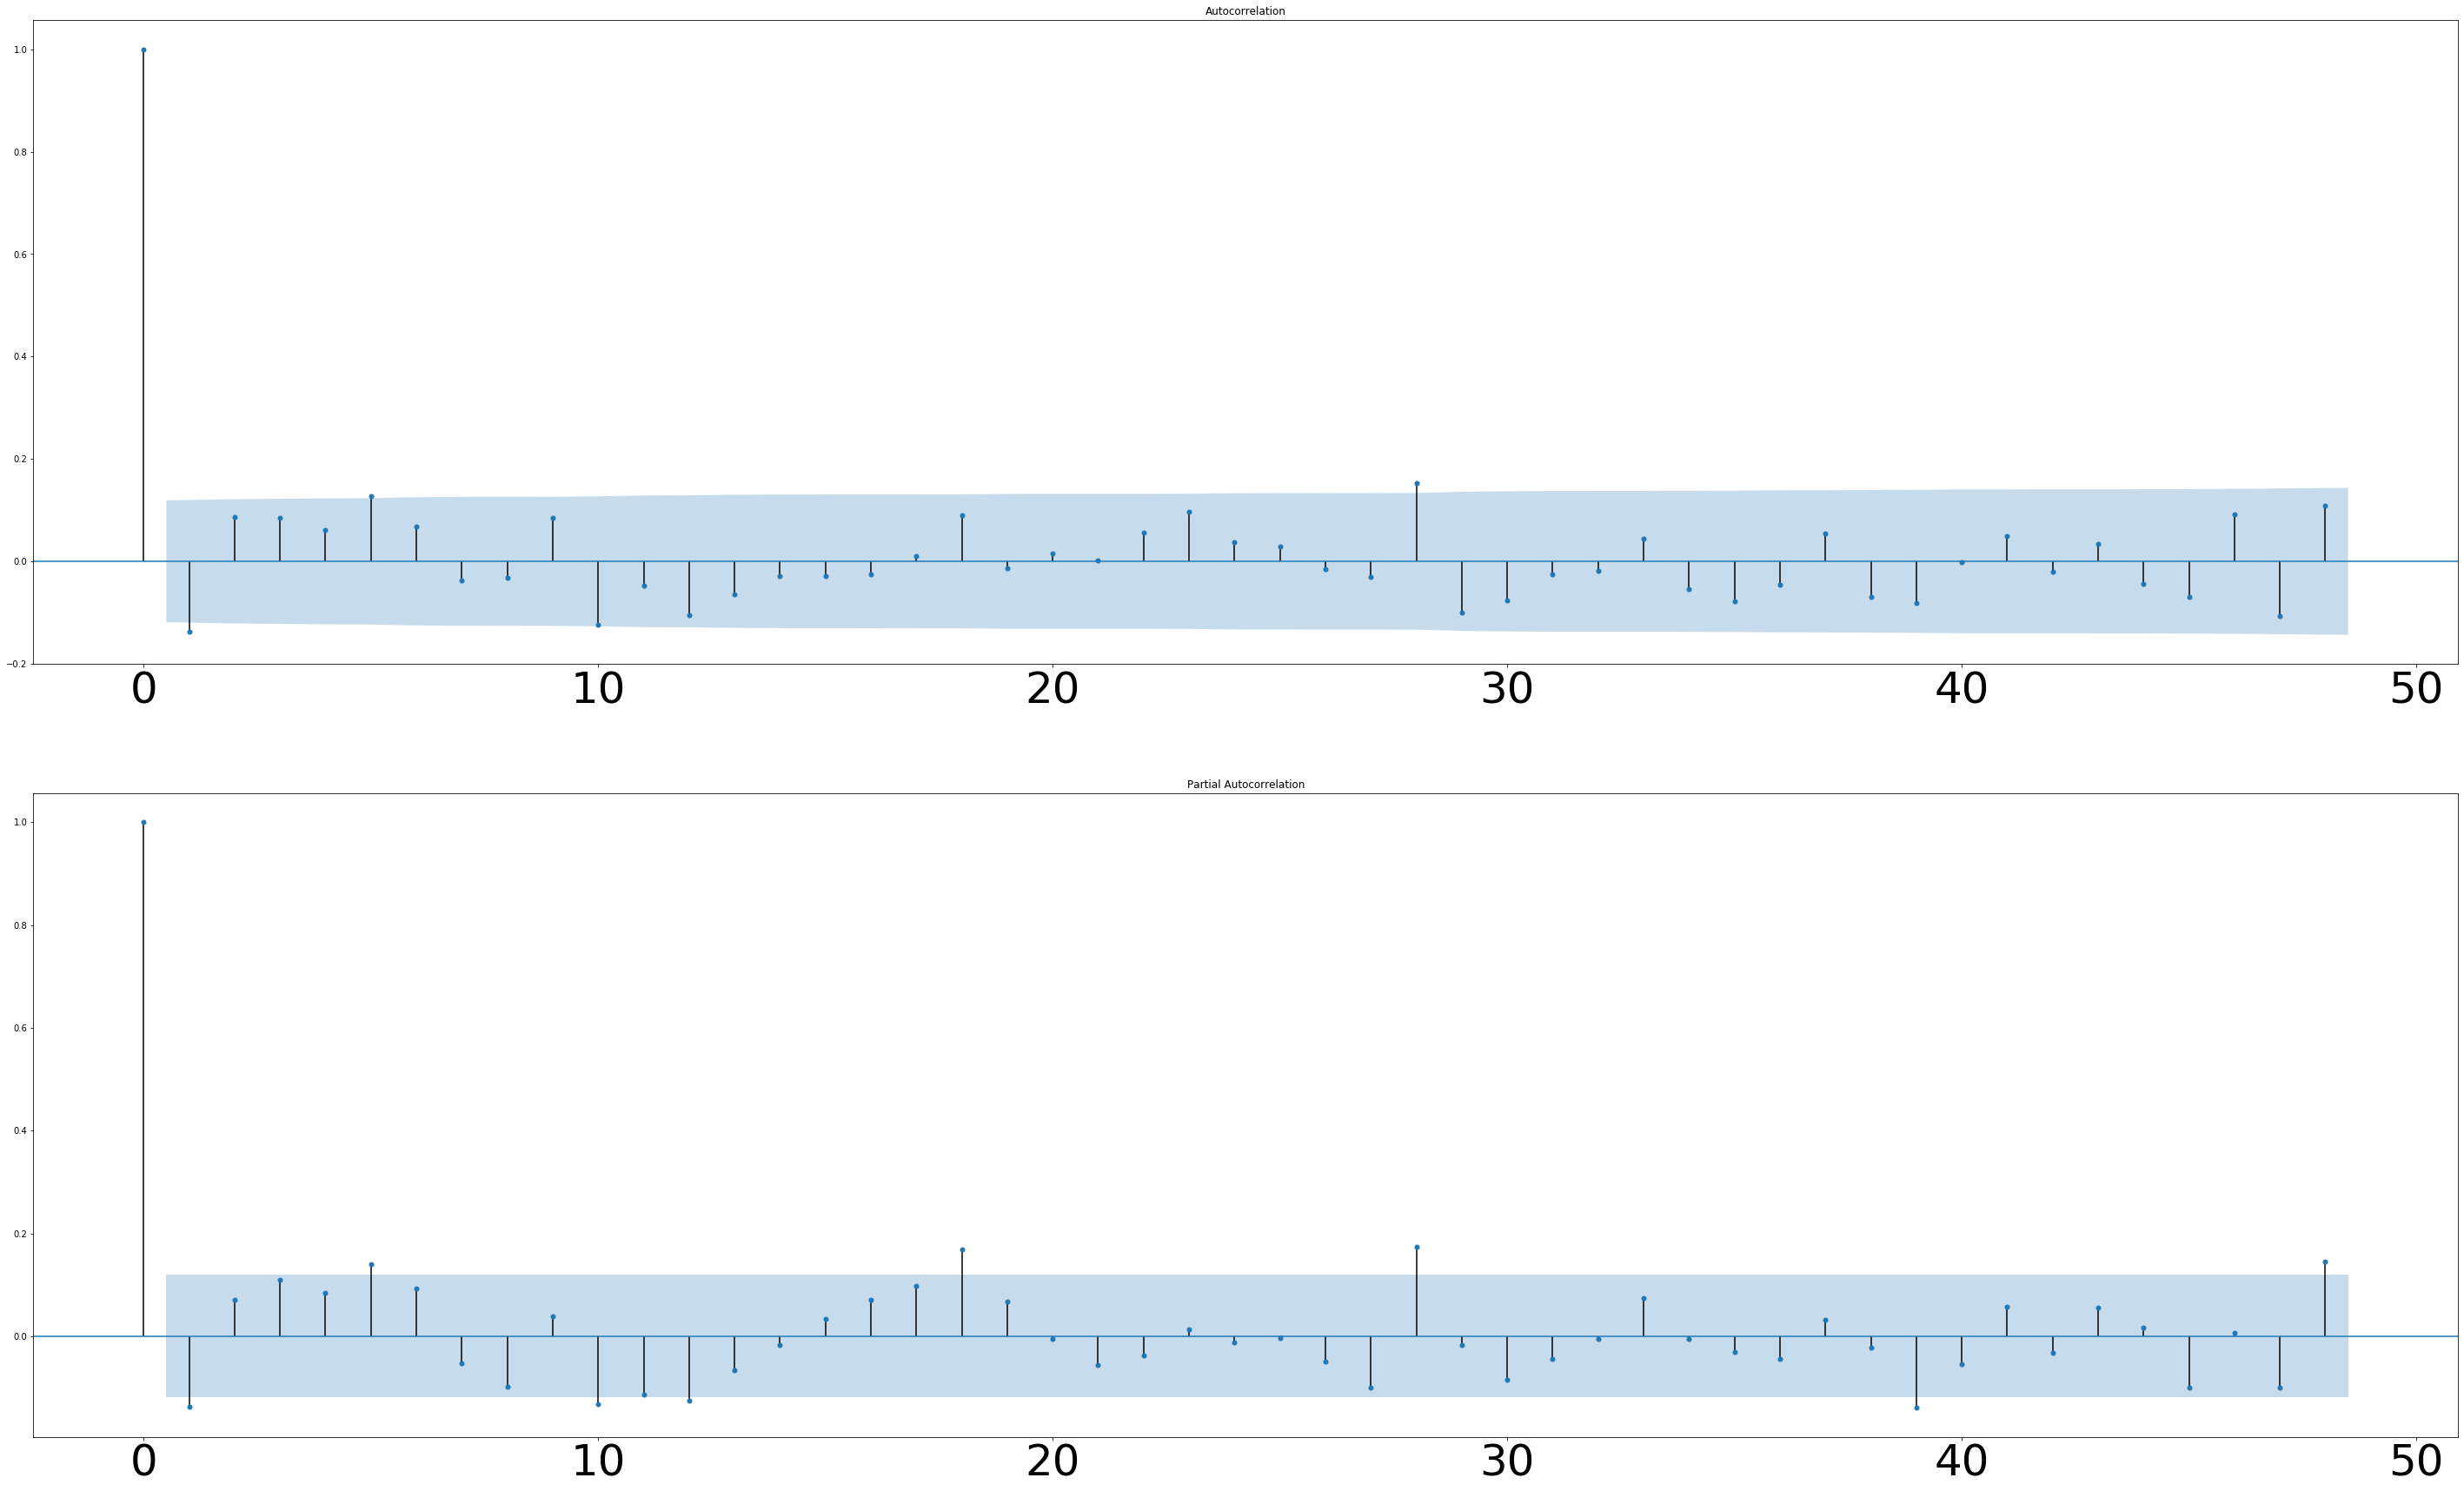

In [150]:
plt.rc('xtick', labelsize=50)
plt.figure(figsize=[50,30])
ax0 = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.box_zp_diff2[13:].values.squeeze(), lags=48, ax=ax0)
ax1 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.box_zp_diff2[13:].values.squeeze(), lags=48, ax=ax1)
plt.show()

Начальные приближения:Q=0 q=5 P=4 p=5

In [151]:
ps = range(0, 5)
d=1
qs = range(0, 5)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [154]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

Перебираем по всем параметрам и находим с наименьшим Аикики

In [157]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box_zp, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')    

CPU times: user 4min 30s, sys: 2.68 s, total: 4min 33s
Wall time: 2min 29s


In [158]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
48  (2, 2, 0, 0) -21.488586
49  (2, 2, 1, 0) -21.473460
52  (2, 3, 0, 0) -21.091484
53  (2, 3, 1, 0) -20.398612
50  (2, 2, 2, 0) -20.309148


In [159]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              box_zp   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Thu, 14 May 2020   AIC                            -21.489
Time:                                     21:39:58   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4854      0.044     33.922      0.000       1.400       1.571
ar.L2         -0.6837      

Критерий Стьюдента: p=0.269874
Критерий Дики-Фуллера: p=0.000000


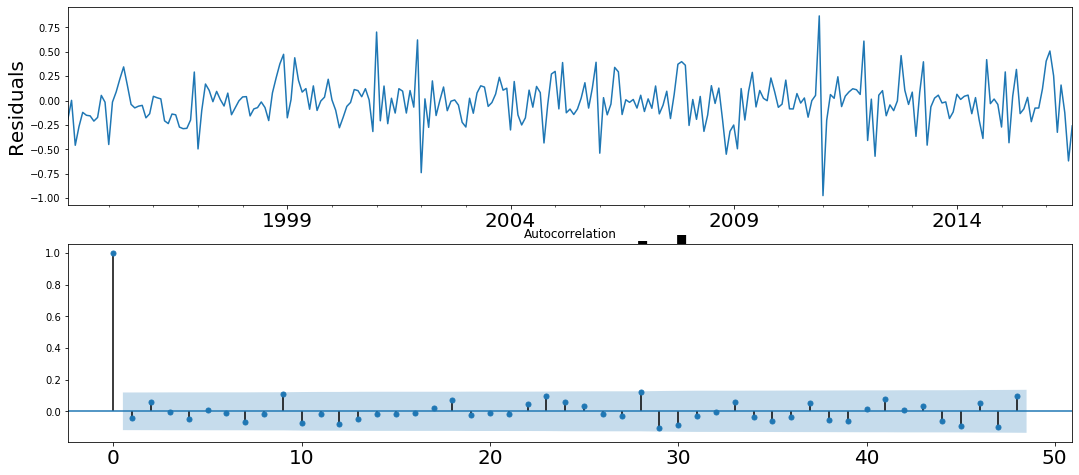

In [164]:
plt.figure(figsize=[18,8])
plt.rc('xtick', labelsize=20)
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals', size=20)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sc.stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

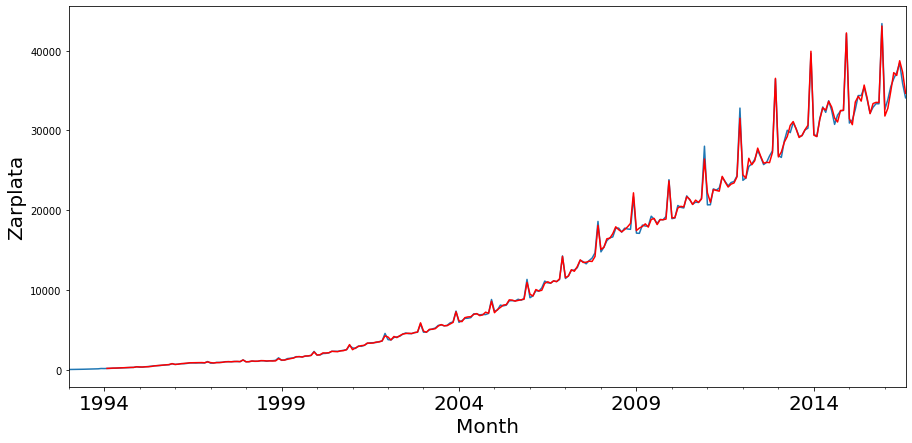

In [171]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=[15,7])
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Zarplata',size=20)
plt.xlabel('Month',size=20)
plt.show()

In [180]:
import datetime

Довольно неплохо, посомтрим, какой прогноз с ее помощью получится построить:

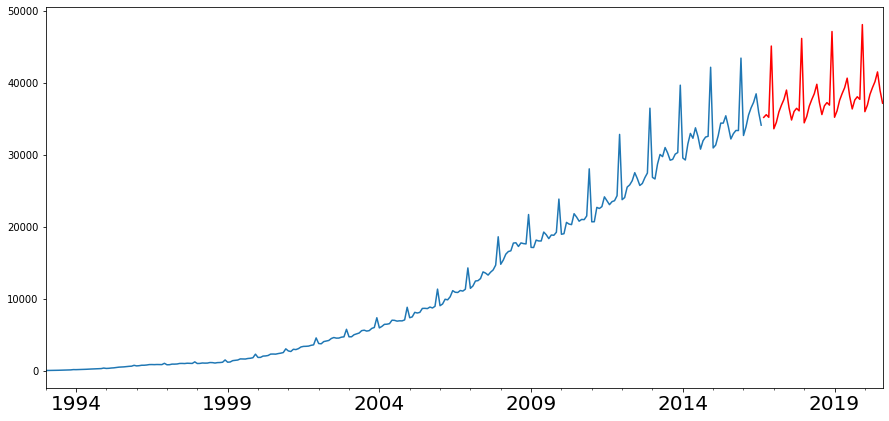

In [210]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=284+48), lmbda)

plt.figure(figsize=[15,7])
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')


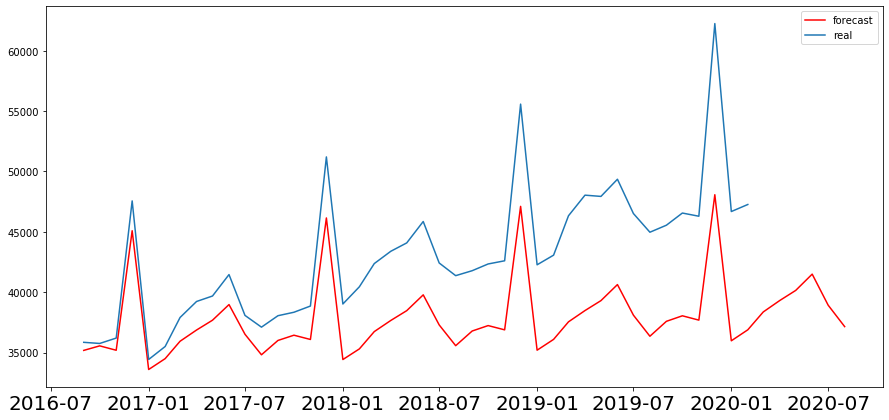

In [231]:
plt.figure(figsize=[15,7])

plt.plot(data2['forecast'][-48:],color='r',label='forecast')
plt.plot(data_real.value,label='real')
plt.legend()

Видим, что со времнем точность прогнозов ухудшается, если их не корректировать из месяца в месяц. Ошибка растет с каждым месяцем, если на основании данных за 2016 год построить данные до 20 года включительно. Осмелюсь предположить, что если бы мы строили прогноз по данным с 2004 года - наш прогноз был бы лучше